### Codes for measuring linear response to tip-tilt aberrations

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load wavelength solution
wavs = np.load('../data/misc/wcal_20230807.npy')

In [11]:
xmin = 20 # minimum x value in pix (not in the range of wavelength solution)
xmax = 300 # maximum x value in pix (not in the range of wavelength solution)

fibindmap = [1,0,2]

# tip-tilt scan steps
xarr = np.linspace(-0.4, 0.4, int(0.4 // 0.04 + 1))

def measure_slopes(spec, plot=False, plot_specinds = []):
    '''
    Measure linear response to tip-tilts
    '''
    spec = np.array(spec)

    slopes = np.zeros((3, len(spec.T)))

    
    for portind in range(3):
        for specind in range(len(spec.T)):
            sum = np.sum(spec.T[specind], axis=0)
            arr = spec.T[specind][portind] / sum
            x = np.polyfit(xarr, arr, 2)
            func = np.poly1d(x)
            slopes[portind][specind] = x[-2]

            
            if plot:
                if specind in plot_specinds:
                    plt.plot(xarr, arr)
                    plt.plot(xarr, func(xarr))
                    plt.title('specind = %d, fibind = %d' % (specind, portind))
                    plt.show()
    return slopes 
            

In [12]:
all_tip_slopes = []
all_tilt_slopes = []


for it in range(5):
    tip0 = fits.getdata('../data/tiptilt_scan/noturb/tip_iter%d.fits' % it)
    tilt0 = fits.getdata('../data/tiptilt_scan/noturb/tilt_iter%d.fits' % it)

    tip_slopes = measure_slopes(tip0)
    tilt_slopes = measure_slopes(tilt0)
    all_tip_slopes.append(tip_slopes)
    all_tilt_slopes.append(tilt_slopes)

all_tip_slopes = np.array(all_tip_slopes)
all_tilt_slopes = np.array(all_tilt_slopes)


all_tip_slopes_t = []
all_tilt_slopes_t = []


for turb_ind in range(3):
    for it in range(5):
        tip0 = fits.getdata('../data/tiptilt_scan/turb0.15um/tip_%d_iter%d.fits' % (turb_ind+1, it))
        tilt0 = fits.getdata('../data/tiptilt_scan/turb0.15um/tilt_%d_iter%d.fits' % (turb_ind+1, it))

        tip_slopes = measure_slopes(tip0)
        tilt_slopes = measure_slopes(tilt0)
        all_tip_slopes_t.append(tip_slopes)
        all_tilt_slopes_t.append(tilt_slopes)

all_tip_slopes_t = np.array(all_tip_slopes_t)
all_tilt_slopes_t = np.array(all_tilt_slopes_t)



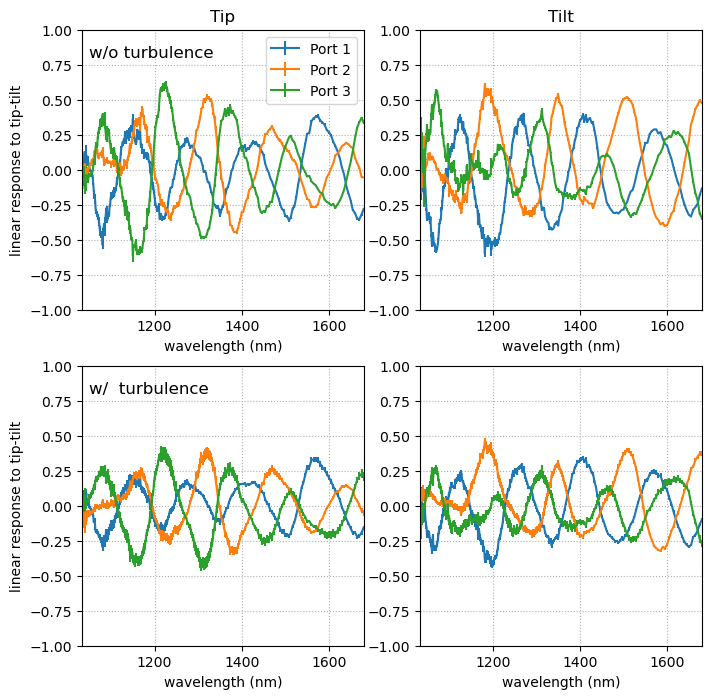

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for fibind0, fibind in enumerate(fibindmap): # fib indices swap
    
    axs[0][0].errorbar(wavs[xmin:xmax], np.average(all_tip_slopes, axis=0)[fibind][xmin:xmax], yerr=np.std(all_tip_slopes, axis=0)[fibind][xmin:xmax]/np.sqrt(len(all_tip_slopes)),
                    label='Port %d' % (fibind0+1),color='C%d' % fibind0)
    axs[0][1].errorbar(wavs[xmin:xmax], np.average(all_tilt_slopes, axis=0)[fibind][xmin:xmax], yerr=np.std(all_tilt_slopes, axis=0)[fibind][xmin:xmax]/np.sqrt(len(all_tilt_slopes)),
                    color='C%d' % fibind0)
    
    
    axs[1][0].errorbar(wavs[xmin:xmax], np.average(all_tip_slopes_t, axis=0)[fibind][xmin:xmax], yerr=np.std(all_tip_slopes_t, axis=0)[fibind][xmin:xmax]/np.sqrt(len(all_tilt_slopes_t)),
                    label='Port %d' % (fibind0+1),color='C%d' % fibind0)
    axs[1][1].errorbar(wavs[xmin:xmax], np.average(all_tilt_slopes_t, axis=0)[fibind][xmin:xmax], yerr=np.std(all_tilt_slopes_t, axis=0)[fibind][xmin:xmax]/np.sqrt(len(all_tilt_slopes_t)),
                    color='C%d' % fibind0)

for ax in axs.flatten():
    ax.set_ylim([-1,1])
    ax.set_xlim([1033, 1680])
    ax.set_xlabel('wavelength (nm)')
    ax.grid(linestyle=':')
axs[0][0].set_ylabel('linear response to tip-tilt')
axs[1][0].set_ylabel('linear response to tip-tilt')
axs[0][0].set_title('Tip')
axs[0][1].set_title('Tilt')
axs[0][0].legend()

axs[0][0].text(1050,0.8,'w/o turbulence',fontsize=12)
axs[1][0].text(1050,0.8,'w/  turbulence',fontsize=12)
plt.show()